### Simulacion caso de uso IRPF

In [5]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn

In [6]:
class SingleOutputModel(nn.Module):
    """
    Small MLP that predicts one output, with positive enforcement via Softplus.
    """
    def __init__(self, in_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.LayerNorm(128),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Softplus()
        )

    def forward(self, x):
        # x: [batch, in_dim]
        return self.net(x)  # output: [batch, 1]


In [7]:
class EnsembleDigitalTwin(nn.Module):
    """
    Wraps 45 independent SingleOutputModel instances,
    one per output category. Forward pass runs all submodels.
    """
    def __init__(self, in_dim: int, n_outputs: int = 45):
        super().__init__()
        # Create a list of submodels
        self.submodels = nn.ModuleList(
            [SingleOutputModel(in_dim) for _ in range(n_outputs)]
        )

    def forward(self, x):
        # x: [batch, in_dim]
        # Collect outputs from each submodel
        outputs = []
        for sub in self.submodels:
            # each out_i is shape [batch, 1]
            outputs.append(sub(x))
        # Concatenate to [batch, n_outputs]
        return torch.cat(outputs, dim=1)

In [8]:
class DigitalTwinModel(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, out_dim)
        )

    def forward(self, x):
        return self.net(x)

In [12]:
# 1) Carga de escaladores y estadísticas (del checkpoint original)
scalers_ckpt = torch.load(
    '../../model/digital_twin_model.pt',
    map_location=torch.device('cpu')
)
scaler_X = scalers_ckpt['scaler_X']
y_means  = scalers_ckpt['y_means']
y_stds   = scalers_ckpt['y_stds']

input_size  = scaler_X.mean_.shape[0]
output_size = y_means.shape[0]

input_size = 29
output_size = 45

state_dict = torch.load(
    '../../model/ensemble_final.pth',
    map_location=torch.device('cpu')
)

# Reconstruir el modelo
model = EnsembleDigitalTwin(input_size, output_size)
model.load_state_dict(state_dict)
model.eval()

C:\Users\rauul\AppData\Local\Temp\ipykernel_14628\3038726041.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  scalers_ckpt = torch.load(
C:\Users\rauul\AppData\Local\Temp

EnsembleDigitalTwin(
  (submodels): ModuleList(
    (0-44): 45 x SingleOutputModel(
      (net): Sequential(
        (0): Linear(in_features=29, out_features=128, bias=True)
        (1): ReLU()
        (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (3): Linear(in_features=128, out_features=64, bias=True)
        (4): ReLU()
        (5): Linear(in_features=64, out_features=1, bias=True)
        (6): Softplus(beta=1.0, threshold=20.0)
      )
    )
  )
)

In [13]:
# --- Función de inferencia adaptada ---
def predict_expenditure(inputs: np.ndarray) -> np.ndarray:
    # 1) Moldea y escala los inputs
    arr = inputs.reshape(1, -1)
    scaled = scaler_X.transform(arr)
    
    # 2) A tensor y paso por el modelo
    tensor = torch.tensor(scaled, dtype=torch.float32)
    with torch.no_grad():
        # Mover a CPU, numpy() solo funciona en CPU tensors
        y_scaled = model(tensor).cpu().numpy().flatten()
    
    # 3) Desnormalizar
    return y_scaled * y_stds + y_means


In [14]:
# --- Cargar datos de hogares ---
df = pd.read_csv('../../datamarts/final_dataframe.tsv', sep='\t')

# Extraer dinámicamente las categorías de gasto (columnas que terminan en _11.._128)
output_columns = [
    col for col in df.columns
    if any(col.endswith(f"_{i}") for i in range(11, 129))
]

# Definir columnas a excluir: salidas más campos auxiliares
excluded_columns = set(output_columns + ['GASTOT_MENSUAL', 'NUMERO', 'CCAA', "Timestamp"])

# Variables de entrada: todas las demás columnas menos las excluidas
feature_cols = [col for col in df.columns if col not in excluded_columns]
X = df[feature_cols].values

# Número de hijos por hogar
num_children = (df['NNINO_FEM'] + df['NNINO_MAS']).astype(int).values

# Carga de tasas de impuesto indirecto (IVA) por categoría
tax_df = pd.DataFrame({
    'code': [11,12,21,22,31,32,41,42,43,44,45,51,52,53,54,55,56,61,62,63,71,72,73,81,82,83,91,92,93,94,95,96,101,102,103,104,111,112,121,123,124,125,126,127,128],
    'iva':  [4,10,21,21,21,21,0,0,10,10,21,21,21,21,21,21,21,4,0,0,21,21,10,21,21,21,21,21,21,10,21,10,0,0,0,0,10,10,21,21,10,21,0,21,0]
})
tax_df['code'] = tax_df['code'].astype(str)
# Ordenar categorías numéricamente y extraer tasas normalizadas
tax_codes = sorted(output_columns, key=lambda x: int(x.split('_')[-1]))
tax_rates = np.array([
    tax_df.loc[tax_df['code']==c.split('_')[-1],'iva'].values[0] / 100
    for c in tax_codes
])
# --- Valores de deducción a simular ---
deduction_values = np.arange(0, 50, 5)  

In [15]:
# --- Selección aleatoria de 200 hogares para la simulación ---
np.random.seed(42)
total = X.shape[0]
sample_idx = np.random.choice(total, size=min(1000,total), replace=False)



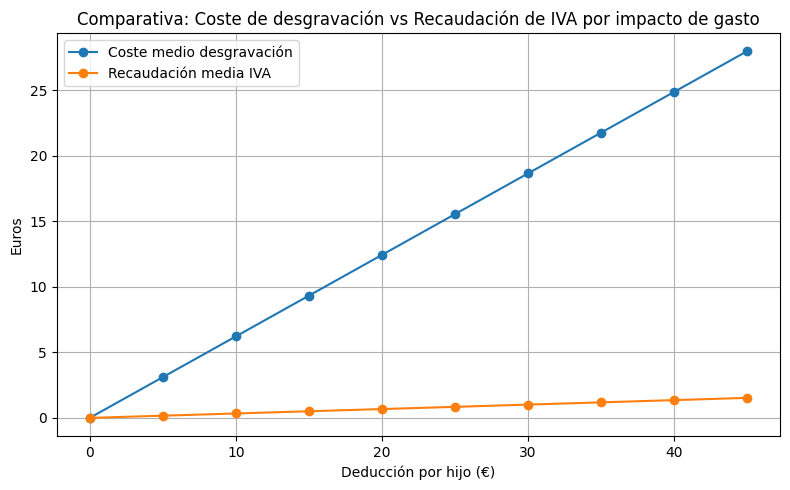

In [16]:
# --- Calcular coste y recaudación media ---
cost_means = {}
revenue_means = {}
for ded in deduction_values:
    # Coste por familia = deducción * número de hijos
    costs = ded * num_children[sample_idx]
    # Impacto medio por categoría (gasto adicional)
    impacts = []
    for idx in sample_idx:
        base = predict_expenditure(X[idx])
        adj_x = X[idx].copy()
        impexac_i = feature_cols.index('IMPEXAC')
        adj_x[impexac_i] += ded * num_children[idx]
        new = predict_expenditure(adj_x)
        impacts.append(new - base)
    impacts = np.array(impacts)  # shape (samples, categories)
    mean_impact = impacts.mean(axis=0)  # vector de impacto medio por categoría
    # Recaudación = sum(impacto_categoria * tasa_categoria)
    revenue = (mean_impact * tax_rates).sum()
    cost_means[ded] = costs.mean()
    revenue_means[ded] = revenue

# DataFrame de resultados
econ_df = pd.DataFrame({
    'Coste medio desgravación': pd.Series(cost_means),
    'Recaudación media IVA por impacto': pd.Series(revenue_means)
})
econ_df.index.name = 'Deducción por hijo (€)'

# --- Gráfica comparativa ---
plt.figure(figsize=(8,5))
plt.plot(econ_df.index, econ_df['Coste medio desgravación'], marker='o', label='Coste medio desgravación')
plt.plot(econ_df.index, econ_df['Recaudación media IVA por impacto'], marker='o', label='Recaudación media IVA')
plt.xlabel('Deducción por hijo (€)')
plt.ylabel('Euros')
plt.title('Comparativa: Coste de desgravación vs Recaudación de IVA por impacto de gasto')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


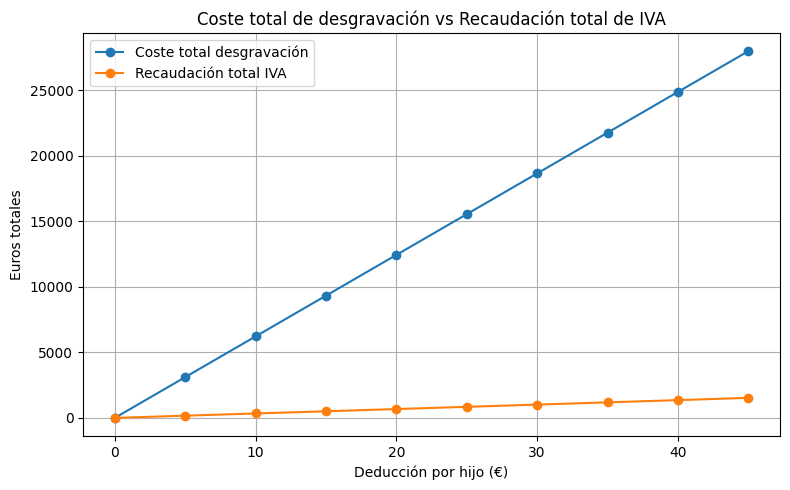

In [17]:
# --- Calcular coste total y recaudación total ---
cost_totals = {}
revenue_totals = {}
for ded in deduction_values:
    # Coste total de la desgravación = suma de deducción * número de hijos por familia
    costs = ded * num_children[sample_idx]
    total_cost = costs.sum()
    # Impacto por categoría (gasto adicional)
    impacts = []
    for idx in sample_idx:
        base = predict_expenditure(X[idx])
        adj_x = X[idx].copy()
        impexac_i = feature_cols.index('IMPEXAC')
        adj_x[impexac_i] += ded * num_children[idx]
        new = predict_expenditure(adj_x)
        impacts.append(new - base)
    impacts = np.array(impacts)  # shape (samples, categories)
    mean_impact = impacts.mean(axis=0)
    # Recaudación total de IVA = suma de impacto medio por categoría * tasa * número de familias
    # Primero, recauda por familia = sum(impacto medio * tasa)
    rev_per_family = (mean_impact * tax_rates).sum()
    total_revenue = rev_per_family * len(sample_idx)
    cost_totals[ded] = total_cost
    revenue_totals[ded] = total_revenue

# Crear DataFrame de resultados
econ_df = pd.DataFrame({
    'Coste total desgravación': pd.Series(cost_totals),
    'Recaudación total IVA': pd.Series(revenue_totals)
})
econ_df.index.name = 'Deducción por hijo (€)'

# --- Gráfica comparativa ---
plt.figure(figsize=(8,5))
plt.plot(econ_df.index, econ_df['Coste total desgravación'], marker='o', label='Coste total desgravación')
plt.plot(econ_df.index, econ_df['Recaudación total IVA'], marker='o', label='Recaudación total IVA')
plt.xlabel('Deducción por hijo (€)')
plt.ylabel('Euros totales')
plt.title('Coste total de desgravación vs Recaudación total de IVA')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Simulacion de impacto en cada categoría

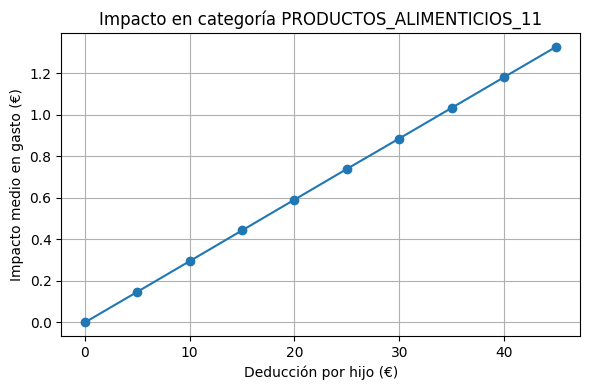

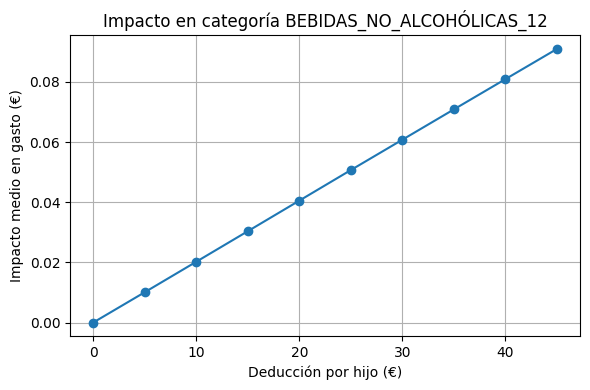

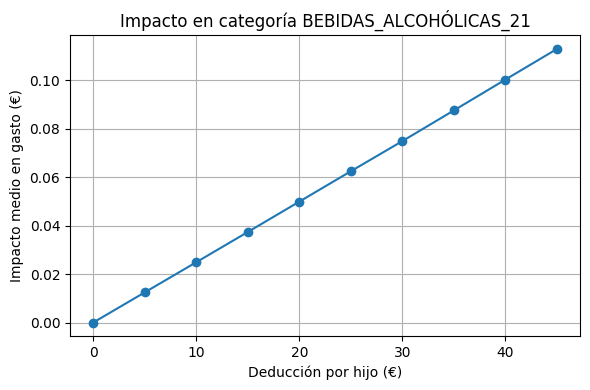

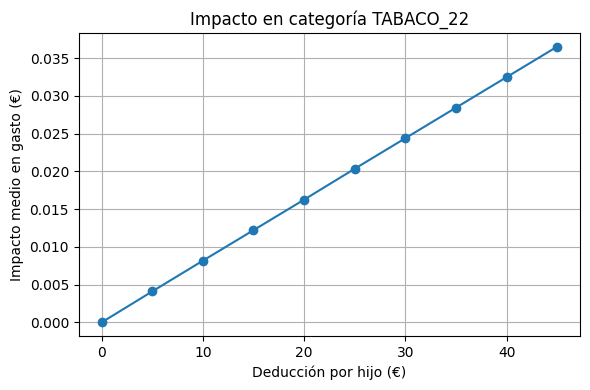

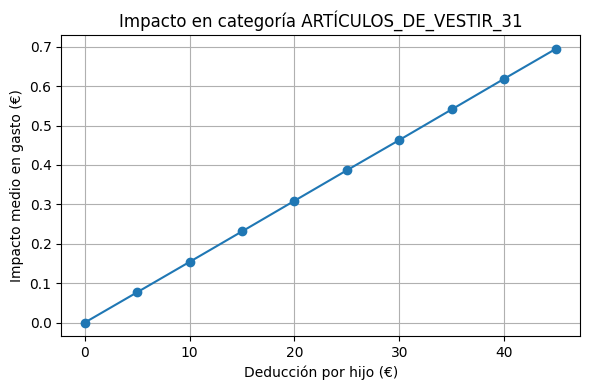

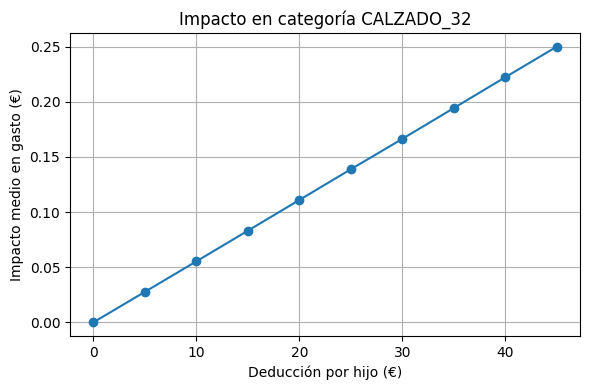

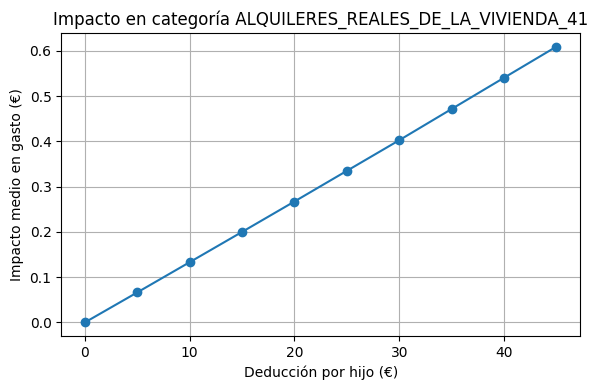

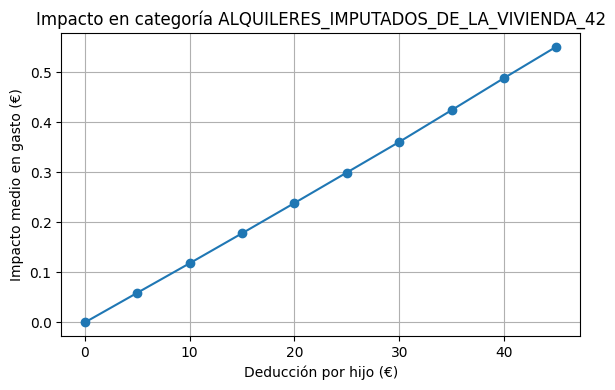

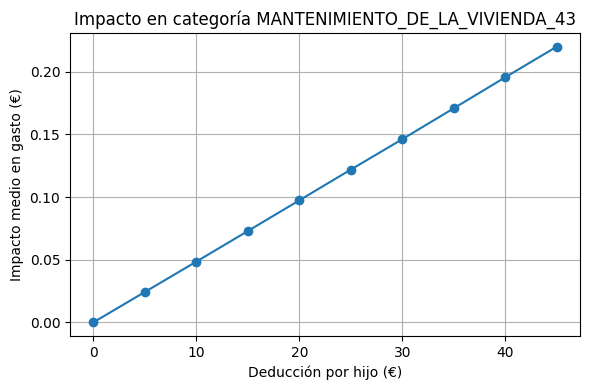

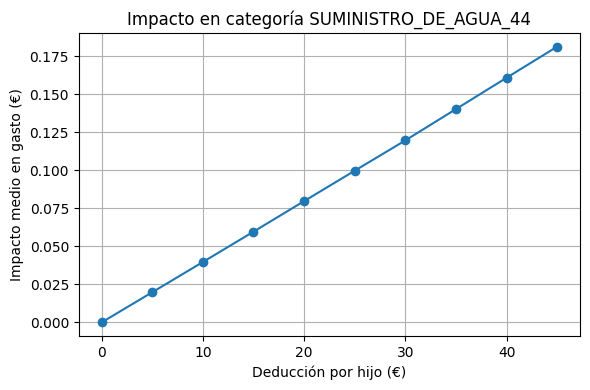

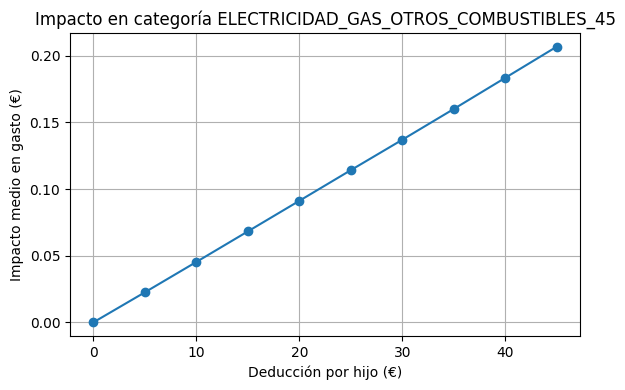

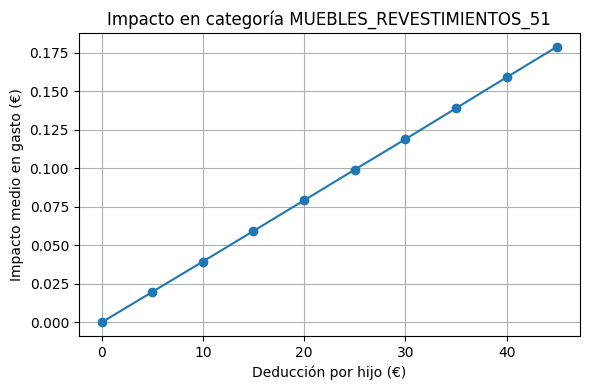

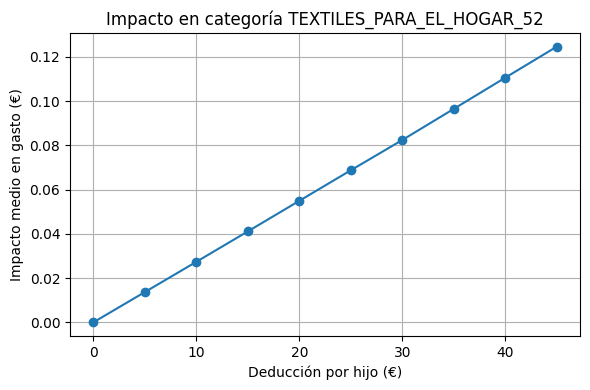

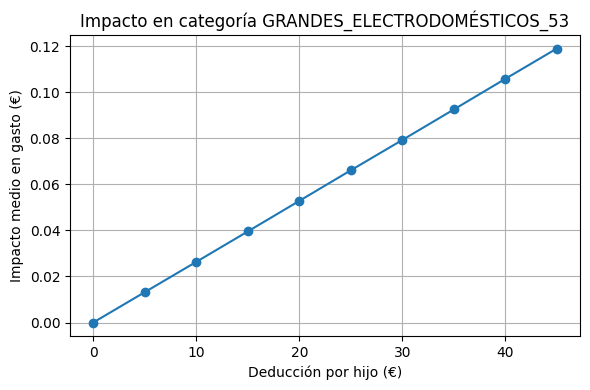

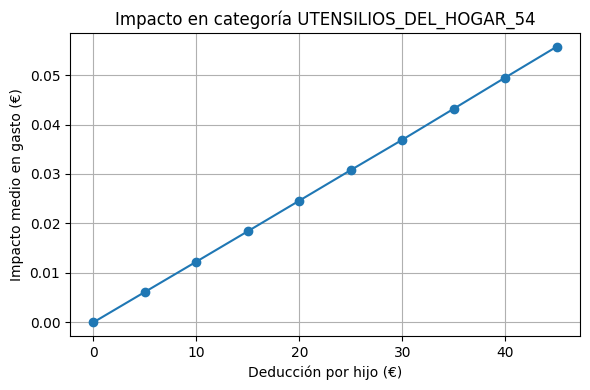

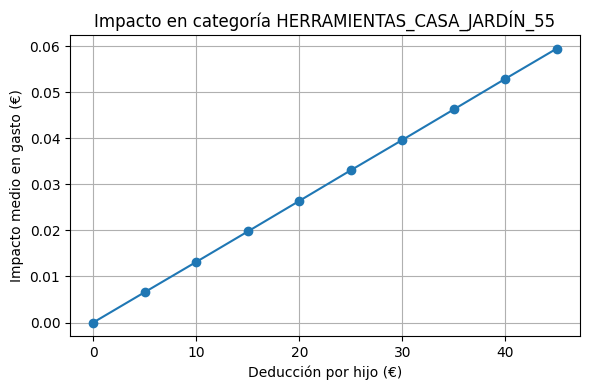

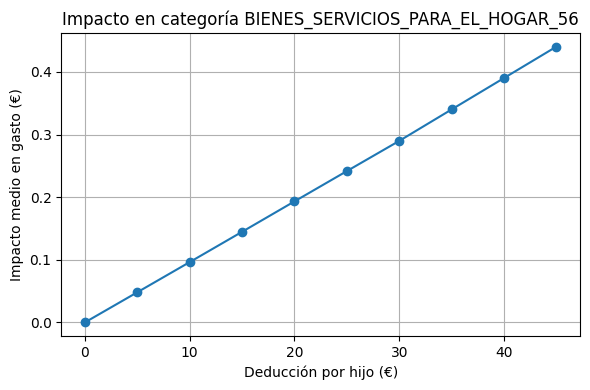

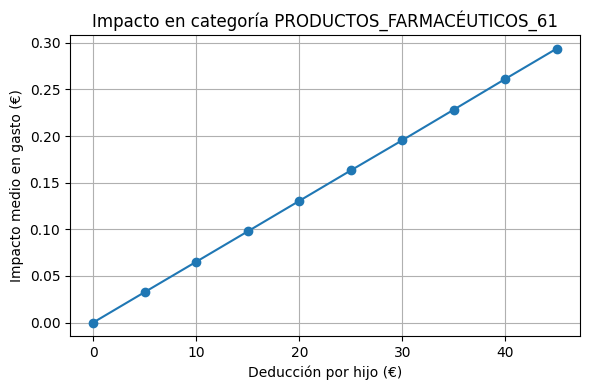

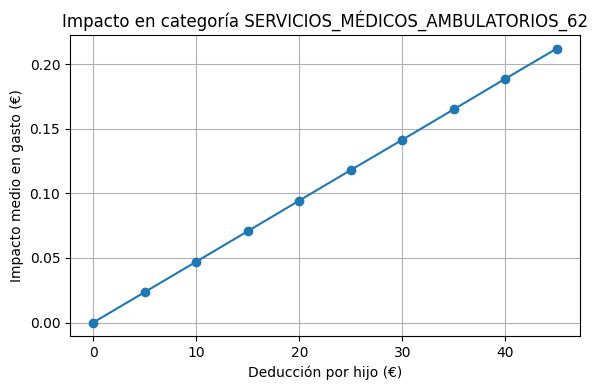

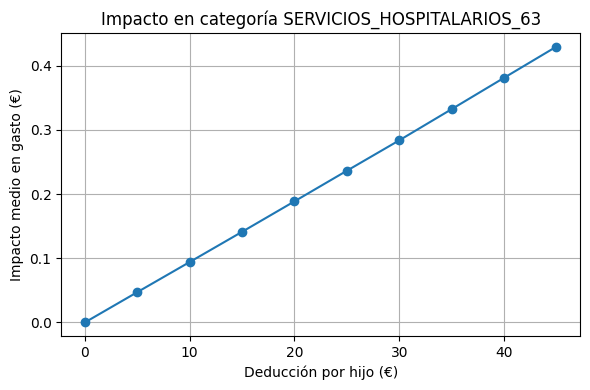

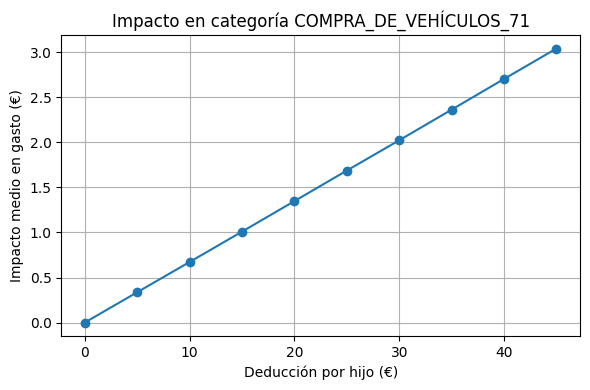

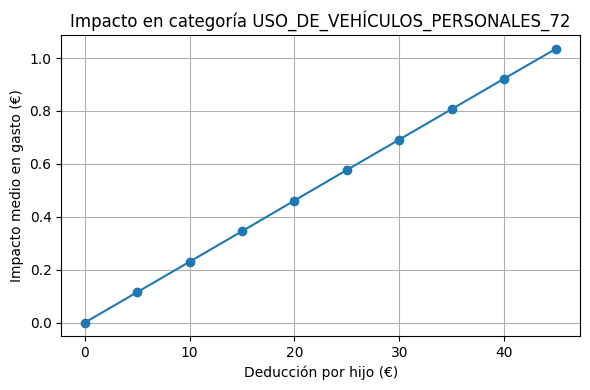

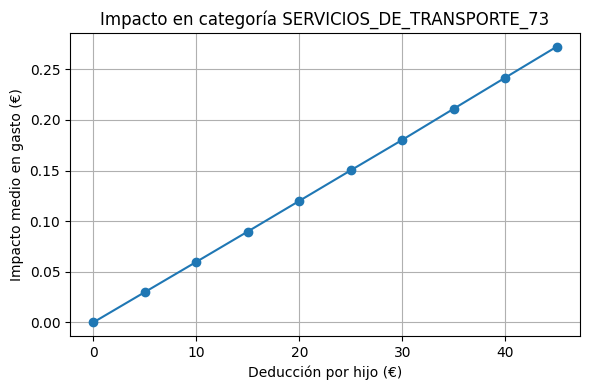

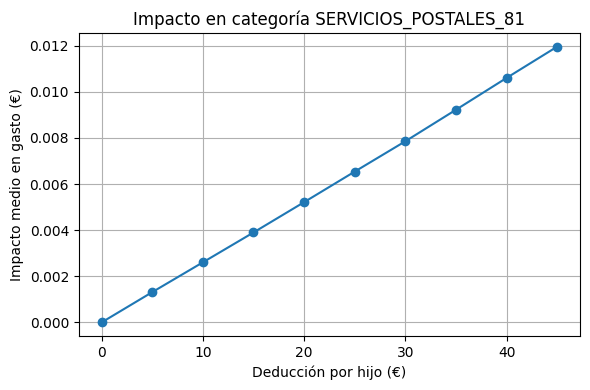

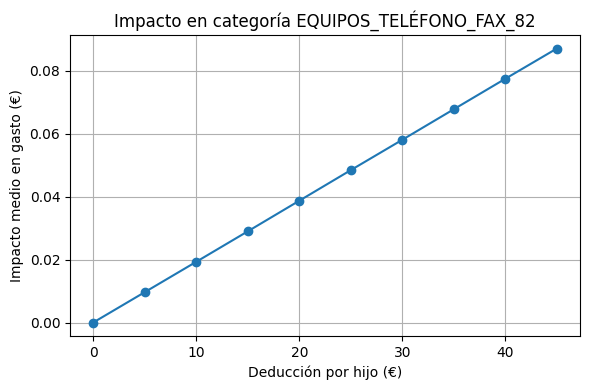

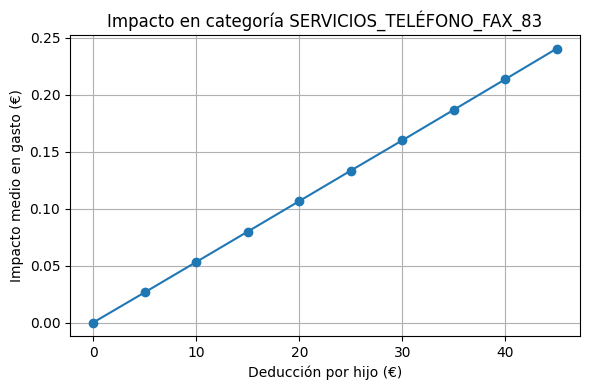

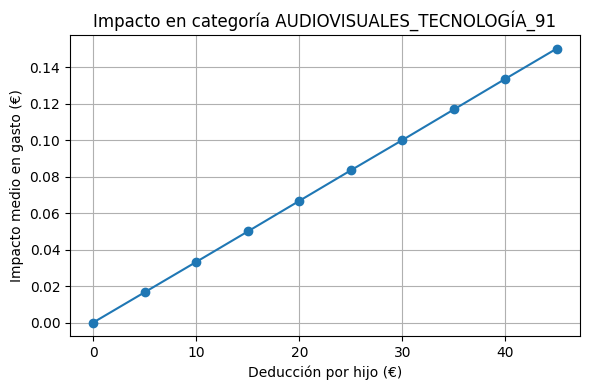

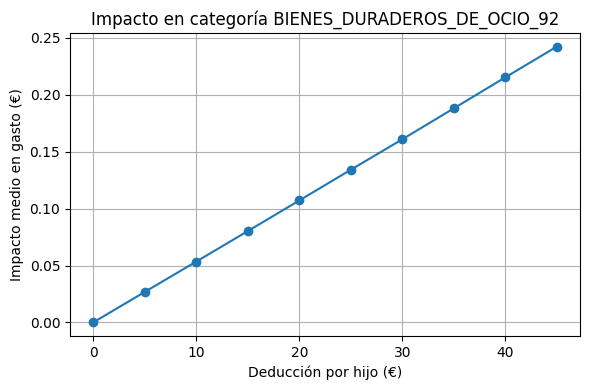

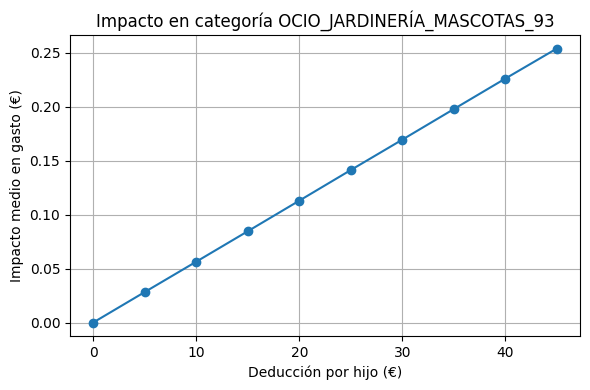

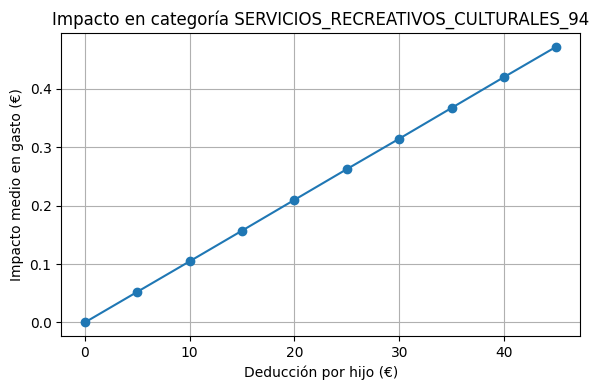

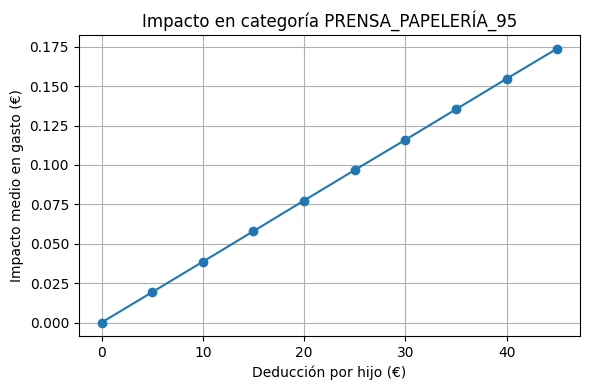

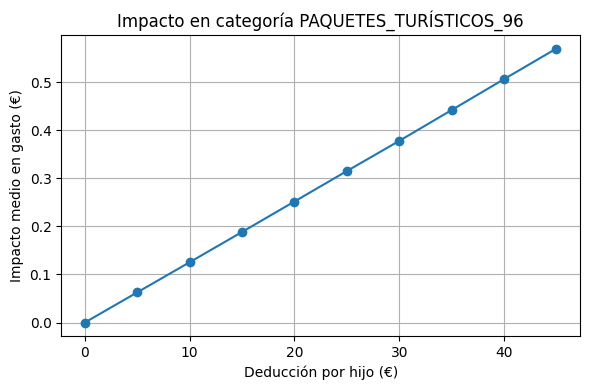

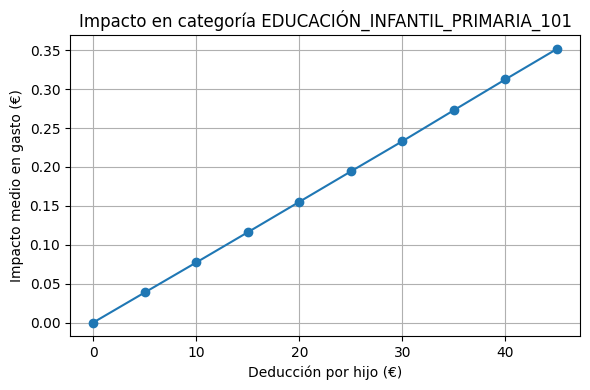

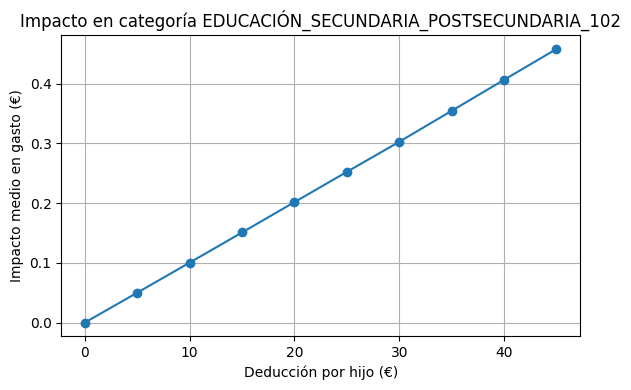

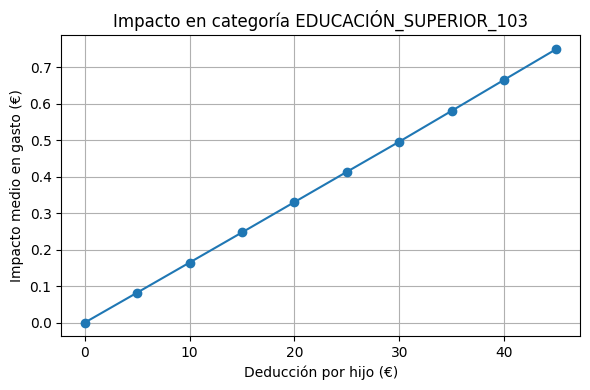

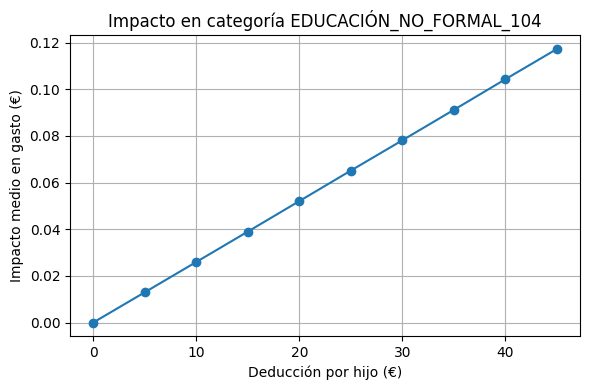

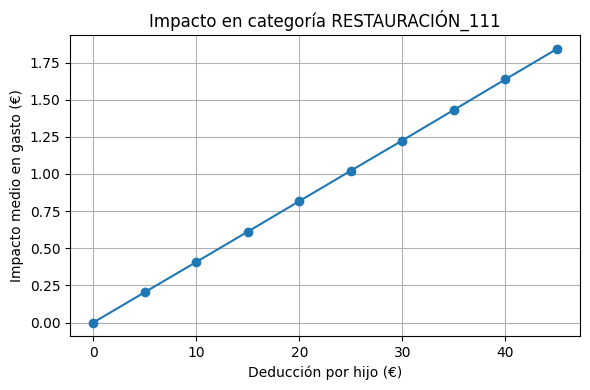

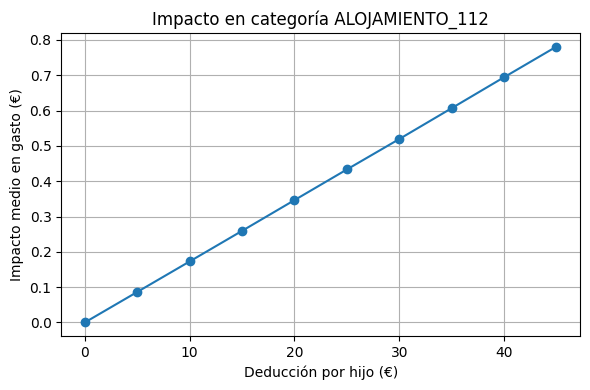

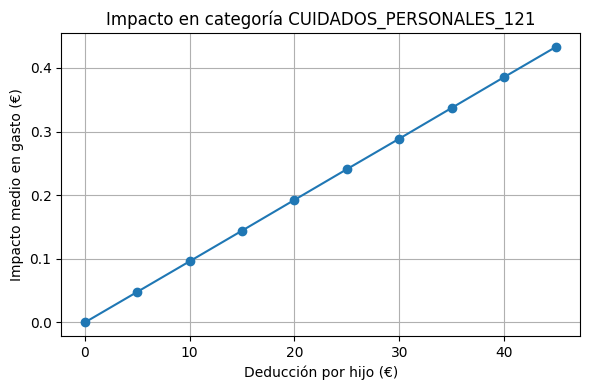

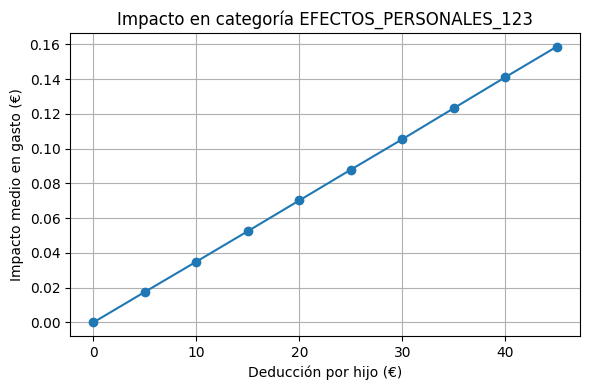

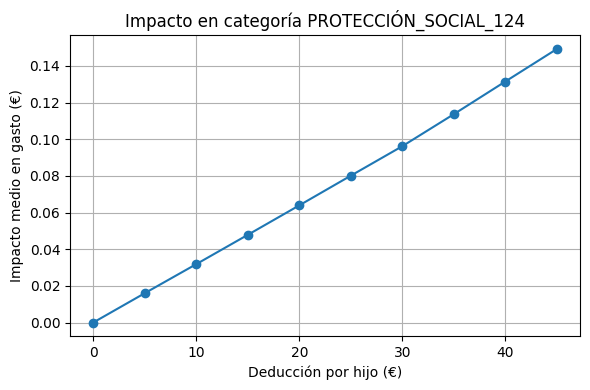

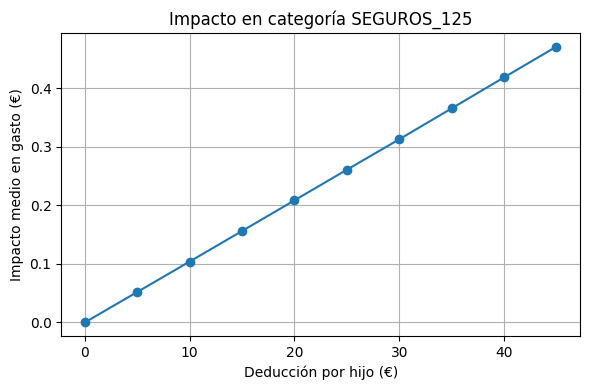

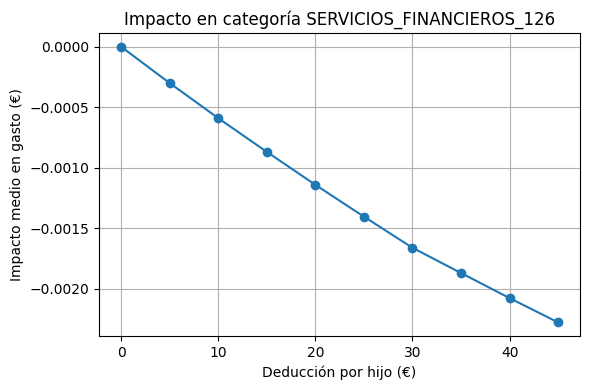

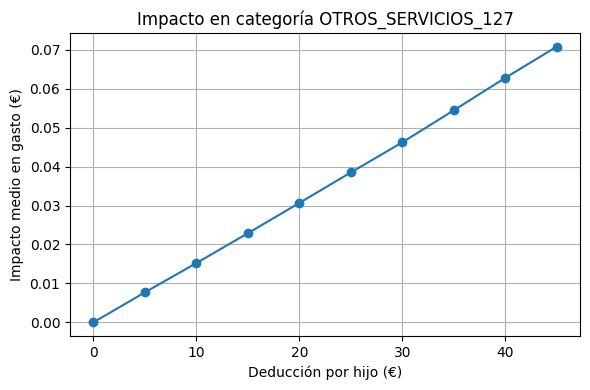

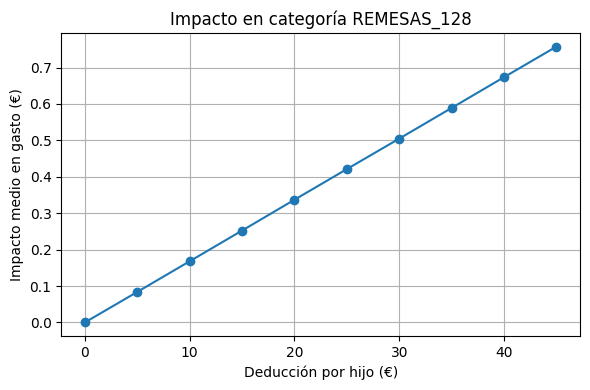

In [ ]:
# --- Graficar una figura por cada categoría ---
for cat in results_df.index:
    plt.figure(figsize=(6, 4))
    plt.plot(
        results_df.columns.astype(int),
        results_df.loc[cat].values,
        marker='o'
    )
    plt.xlabel('Deducción por hijo (€)')
    plt.ylabel('Impacto medio en gasto (€)')
    plt.title(f'Impacto en categoría {cat}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()